In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import expit

In [2]:
def propagate(X, V, W, b):
    if isinstance(X, (int, float)):
        X = np.array([X])
    U1 = np.einsum("ij,j->i", V, X) + b
    Z = f_act(U1)
    U2 = np.einsum("ij,j->i", W, Z)
    Y = U2
    return Y, Z, U1, U2

def backpropagate(X, YT, V, W, b):
    Y, Z, U1, U2 = propagate(X, V, W, b)
    # output layer
    ##########################################
    delta3 = -(Y - YT) # error layer 3
    delta2 = np.einsum("ij,i->j", W, delta3) * f_act_prime(U1) # error layer 2
    dW = np.einsum("i,j->ij", delta3, Z)
    dV = np.einsum("i,j->ij", delta2, X)
    db = delta2              
    ##########################################
    return db, dV, dW, Cost(Y,YT)


relu = lambda v: np.maximum(v, 0.0)
relu_prime = lambda v: np.where(v>0.0, np.ones_like(v), np.zeros_like(v))
expit_derivative = lambda x: expit(x) * (1-expit(x))
f_act = expit
f_act_prime = expit_derivative

Cost = lambda Y, YT: 1./2. * np.mean((Y - YT)**2)


In [3]:
def train(X, YT, V, W, b, niter=10000, base_lr=0.2):
    """
    data                             X
    target values                    YT
    input->hidden weights            V
    hidden->output weights           W
    hidden biases                    b
    number of training iterations    niter
    learning rate                    base_lr
    """
    SEED = 734589
    np.random.seed(SEED)

    K = len(b)
    eta = base_lr / K
    mu = 0.5
    T = np.random.randint(0, len(X), niter)

    cost = np.zeros(len(T))
    # prepare momentum term variables
    delta_W = np.zeros((1, K))
    delta_b = np.zeros(K)
    delta_V = np.zeros((K, 1))

    for run, inp in enumerate(T):
        if isinstance(X[inp], (int, float)):
            db, dV, dW, cost[run] = backpropagate([X[inp]], YT[inp], V, W, b)
        else:
            db, dV, dW, cost[run] = backpropagate(X[inp], YT[inp], V, W, b)
        # calculate weight update with momentum
        # instead of applying the gradients directly
        # this applies a low-pass filtered version
        # which smooths out the updates and helps
        # stabilise the training
        # https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum
        delta_b = (1.-mu) * db + mu * delta_b
        delta_V = (1.-mu) * dV + mu * delta_V
        delta_W = (1.-mu) * dW + mu * delta_W
        # update weights
        b += eta * delta_b
        V += eta * delta_V
        W += eta * delta_W
    
    return V, W, b, cost

In [4]:
data = np.load("resources/func_approx_training.npz")
X = data['X']
YT = data['Y']
K = 40

V = np.random.normal(0., 1., (K,1))
W = np.random.normal(0., 1., (1,K))
b = np.random.normal(0., 1., K)
'''
V = np.array([[1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
W = np.array([[1.05, -2.0, 1.0]])
b = np.array([0.0, -1.0, 0.0])
'''

'\nV = np.array([[1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])\nW = np.array([[1.05, -2.0, 1.0]])\nb = np.array([0.0, -1.0, 0.0])\n'

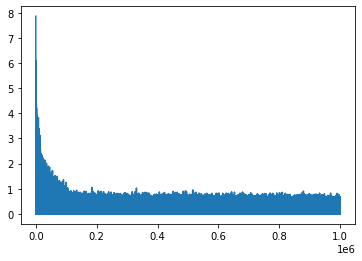

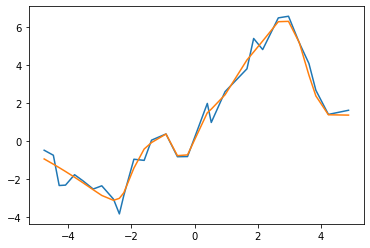

In [5]:
V, W, b, cost = train(X, YT, V, W, b, niter=int(1e6))
avgcost = [np.mean(cost[n-10:n+10]) for n in range(10, len(cost)-10)]
plt.plot(range(int(1e6)), cost)
plt.show()

yval = []
for xval in X:
    yval.append(propagate(xval, V, W, b)[0])

plt.plot(X, YT)
plt.plot(X, yval)
plt.show()